In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob, os
import numpy as np
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

(17931, 96, 96) (6000, 3)


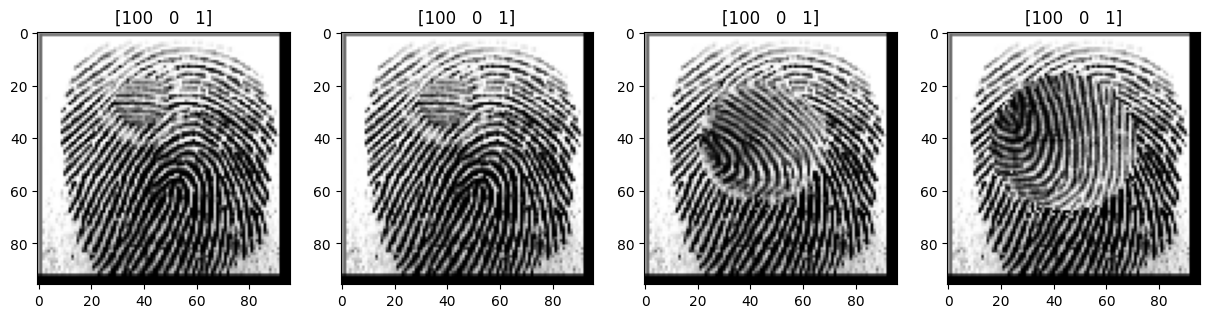

In [2]:
x_real = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_easy.npz')['data']
x_easy = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_easy.npz')['data']
x_medium = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_medium.npz')['data']
x_hard = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/x_hard.npz')['data']
y_real = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_real.npy')
y_easy = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_easy.npy')
y_medium = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_medium.npy')
y_hard = np.load('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)

plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)

plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)

plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)

plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')


C:\Users\h4uh4\AppData\Roaming\Python\Python310\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


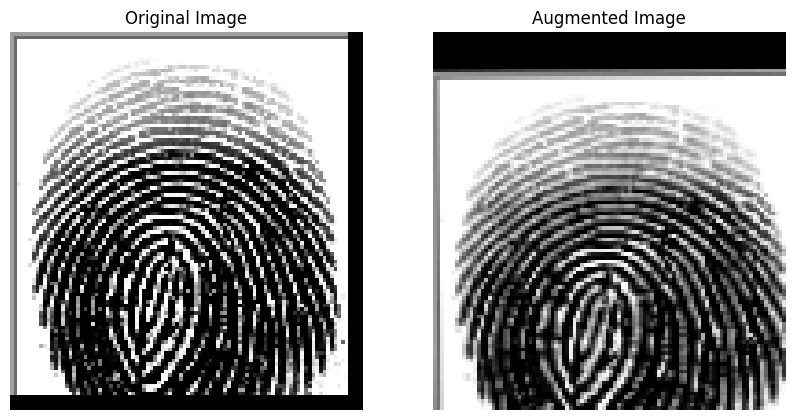

In [ ]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A


image = cv2.imread('C:/Users/h4uh4/OneDrive/Desktop/Skripsi_Bimbingan/Fingerprint/DataFinal/SOCOFing/Real/1__M_Left_index_finger.BMP')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, rotate=(-5, 5), p=0.7),



])






augmented = augment(image=image)
augmented_image = augmented['image']


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_image)
plt.axis('off')

plt.show()


In [ ]:

x_real = x_real[:len(y_real)]


x_data = np.concatenate([x_real, x_easy, x_medium, x_hard], axis=0)
y_data = np.concatenate([y_real, y_easy, y_medium, y_hard], axis=0)

print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")


half_size = len(x_data) // 2

x_data_half = x_data[:half_size]
y_data_half = y_data[:half_size]

print(f"x_data_half shape: {x_data_half.shape}")
print(f"y_data_half shape: {y_data_half.shape}")



assert x_data_half.shape[0] == y_data_half.shape[0], "Jumlah sample x_data dan y_data tidak sama!"


x_temp, x_test, y_temp, y_test = train_test_split(x_data_half, y_data_half, test_size=0.2, random_state=42)


x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)


print(f"Train set size: {x_train.shape[0]} samples")
print(f"Validation set size: {x_val.shape[0]} samples")
print(f"Test set size: {x_test.shape[0]} samples")


x_data shape: (55270, 96, 96)
y_data shape: (55270, 3)
x_data_half shape: (27635, 96, 96)
y_data_half shape: (27635, 3)
Train set size: 16581 samples
Validation set size: 5527 samples
Test set size: 5527 samples


In [ ]:

print("Memeriksa dataset raw untuk NaN atau Inf...")

if np.any(np.isnan(x_data_half)) or np.any(np.isinf(x_data_half)):
    print("NaN atau Inf terdeteksi pada dataset raw!")
else:
    print("Dataset raw bersih dari NaN atau Inf.")


Memeriksa dataset raw untuk NaN atau Inf...
Dataset raw bersih dari NaN atau Inf.


In [ ]:

x_train = np.expand_dims(x_train, -1).astype('float32') / 255.
x_val = np.expand_dims(x_val, -1).astype('float32') / 255.
x_test = np.expand_dims(x_test, -1).astype('float32') / 255.


Memory usage: 66.5%


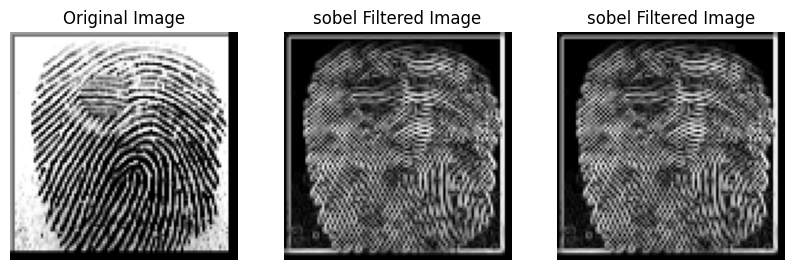

In [ ]:
import cv2
import numpy as np
import psutil
import matplotlib.pyplot as plt


def apply_sobel_filter(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return cv2.magnitude(sobel_x, sobel_y)


x_train_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_train])
x_val_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_val])
x_test_sobel = np.array([apply_sobel_filter(img.squeeze()) for img in x_test])
import psutil
print(f"Memory usage: {psutil.virtual_memory().percent}%")



plt.figure(figsize=(10, 5))


plt.subplot(1, 3, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(x_train_sobel[0], cmap='gray')
plt.title("sobel Filtered Image")
plt.axis('off')


plt.subplot(1, 3, 3)
sobel_result = apply_sobel_filter(x_train[0])
plt.imshow(sobel_result, cmap='gray')
plt.title("sobel Filtered Image")
plt.axis('off')

plt.show()


In [ ]:
import gc


gc.collect()


7331

In [ ]:

x_train_sobel = np.nan_to_num(x_train_sobel)
x_val_sobel = np.nan_to_num(x_val_sobel)
x_test_sobel = np.nan_to_num(x_test_sobel)


x_train_sobel = np.expand_dims(x_train_sobel, -1).astype('float32') / np.max(x_train_sobel)
x_val_sobel = np.expand_dims(x_val_sobel, -1).astype('float32') / np.max(x_val_sobel)
x_test_sobel = np.expand_dims(x_test_sobel, -1).astype('float32') / np.max(x_test_sobel)


In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import Sequence


def ensure_rgb(image):
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)
    return image


x_train_sobel_rgb = np.array([ensure_rgb(img) for img in x_train_sobel])


class PairGenerator(Sequence):
    def __init__(self, x, y, x_real, y_real, batch_size=32, augment_fn=None):
        self.x = x
        self.y = y
        self.x_real = x_real
        self.y_real = y_real
        self.batch_size = batch_size
        self.augment_fn = augment_fn


        self.label_real_dict = {}
        for idx, label in enumerate(self.y_real):
            key = ''.join(label.astype(str)).zfill(6)
            if key not in self.label_real_dict:
                self.label_real_dict[key] = []
            self.label_real_dict[key].append(idx)

        self.label_keys = list(self.label_real_dict.keys())

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.x))


        x1_batch = np.empty((end - start, 96, 96, 3), dtype=np.float32)
        x2_batch = np.empty((end - start, 96, 96, 3), dtype=np.float32)
        y_batch = self.y[start:end]
        batch_size = len(x1_batch)

        labels = np.zeros((batch_size, 1), dtype=np.float32)

        for i, label in enumerate(y_batch):
            key = ''.join(label.astype(str)).zfill(6)

            if random.random() > 0.5 and key in self.label_real_dict:
                idx = random.choice(self.label_real_dict[key])
                x2 = self.x_real[idx]
                labels[i] = 1.
            else:
                while True:
                    unmatch_key = random.choice(self.label_keys)
                    if unmatch_key != key:
                        idx = random.choice(self.label_real_dict[unmatch_key])
                        x2 = self.x_real[idx]
                        break
                labels[i] = 0.

            x2_batch[i] = x2


            x1_batch[i] = self.x[start + i]
            x2_batch[i] = x2


            if self.augment_fn:

                if isinstance(x1_batch[i], np.ndarray):
                    x1_batch[i] = self.augment_fn(image=x1_batch[i])['image']
                elif isinstance(x1_batch[i], tf.Tensor):
                    x1_batch[i] = self.augment_fn(image=x1_batch[i].numpy())['image']
                
                if isinstance(x2_batch[i], np.ndarray):
                    x2_batch[i] = self.augment_fn(image=x2_batch[i])['image']
                elif isinstance(x2_batch[i], tf.Tensor):
                    x2_batch[i] = self.augment_fn(image=x2_batch[i].numpy())['image']

        return (x1_batch, x2_batch), labels


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models


def build_resnet_model(input_shape=(96, 96, 3)):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = False
    

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)


    model = models.Model(inputs=base_model.input, outputs=output)

    return model


x1 = layers.Input(shape=(96, 96, 3))
x2 = layers.Input(shape=(96, 96, 3))


resnet_model = build_resnet_model()


f1 = resnet_model(x1)
f2 = resnet_model(x2)


diff = layers.Subtract()([f1, f2])


x = layers.Dense(128, activation='relu')(diff)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)


model = models.Model(inputs=[x1, x2], outputs=output)


model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 1)         │ 25,955,457 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │        256 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,964,034 (99.04 MB)

 Trainable params: 2,376,322 (9.06 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

print("Memeriksa dataset setelah filter Laplacian...")

if np.any(np.isnan(x_train_sobel)) or np.any(np.isinf(x_train_sobel)):
    print("NaN atau Inf terdeteksi pada dataset yang sudah difilter!")
else:
    print("Dataset yang sudah difilter bersih dari NaN atau Inf.")


Memeriksa dataset setelah filter Laplacian...
Dataset yang sudah difilter bersih dari NaN atau Inf.


In [13]:
train_gen = PairGenerator(x_train_sobel_rgb, y_train, x_train_sobel_rgb, y_train, batch_size=32, augment_fn=augment)
val_gen = PairGenerator(x_val, y_val, x_val, y_val, batch_size=32, augment_fn=None)


In [ ]:

print(f"NaN atau Inf terdeteksi pada x_train_sobel setelah filter sobel: {np.any(np.isnan(x_train_sobel_rgb)) or np.any(np.isinf(x_train_sobel_rgb))}")


print(f"NaN atau Inf terdeteksi pada x_val_sobel setelah filter sobel: {np.any(np.isnan(x_val_sobel)) or np.any(np.isinf(x_val_sobel))}")
print(f"NaN atau Inf terdeteksi pada x_test_sobel setelah filter sobel: {np.any(np.isnan(x_test_sobel)) or np.any(np.isinf(x_test_sobel))}")


NaN atau Inf terdeteksi pada x_train_sobel setelah filter sobel: False
NaN atau Inf terdeteksi pada x_val_sobel setelah filter sobel: False
NaN atau Inf terdeteksi pada x_test_sobel setelah filter sobel: False


Batch 1:
x1 batch shape: (32, 96, 96, 3)
x2 batch shape: (32, 96, 96, 3)
Labels shape: (32, 1)


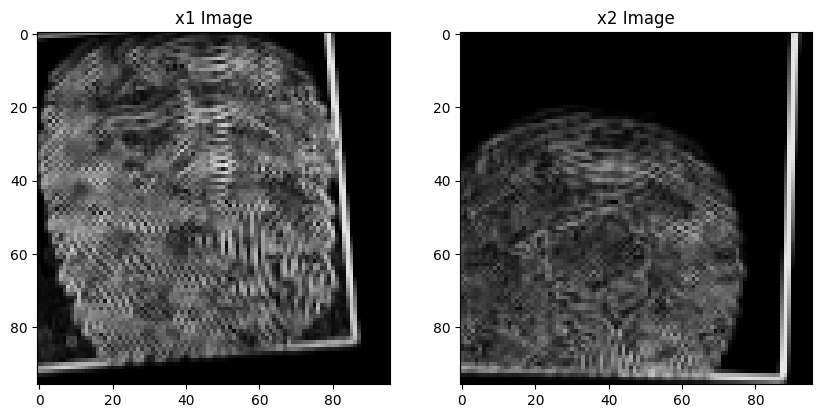

Batch 2:
x1 batch shape: (32, 96, 96, 3)
x2 batch shape: (32, 96, 96, 3)
Labels shape: (32, 1)


In [ ]:
import matplotlib.pyplot as plt


for i, (inputs, labels) in enumerate(train_gen):

    print(f"Batch {i + 1}:")
    print(f"x1 batch shape: {inputs[0].shape}")
    print(f"x2 batch shape: {inputs[1].shape}")
    print(f"Labels shape: {labels.shape}")


    if i == 0:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(inputs[0][0].squeeze(), cmap='gray')
        plt.title('x1 Image')

        plt.subplot(1, 2, 2)
        plt.imshow(inputs[1][0].squeeze(), cmap='gray')
        plt.title('x2 Image')

        plt.show()


    if i >= 1:
        break

In [ ]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('sobel_best.keras', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint, early_stop, lr_scheduler],
    verbose=2
)

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm


test_gen = PairGenerator(x_test_sobel, y_test, x_test_sobel, y_test, batch_size=32, augment_fn=augment)

x1_list, x2_list, y_list = [], [], []
for i in range(len(test_gen)):
    (x1_batch, x2_batch), y_batch = test_gen[i]
    x1_list.append(x1_batch)
    x2_list.append(x2_batch)
    y_list.append(y_batch)

x_test_1 = np.concatenate(x1_list, axis=0)
x_test_2 = np.concatenate(x2_list, axis=0)
y_test_full = np.concatenate(y_list, axis=0)
y_test_full = y_test_full[:len(x_test_1)] 

print("Shapes:", x_test_1.shape, x_test_2.shape, y_test_full.shape)


model_local = load_model('C:/Users/h4uh4/OneDrive/Desktop/FinalCompareFriedman/Model_Resnet/ModelResnet/sobel_resnet_final_model.keras')

B = 100
n = len(x_test_1)
num_classes = len(np.unique(y_test_full))
results = []


for seed in tqdm(range(B), total=B):
    np.random.seed(seed)
    idx = np.random.choice(n, size=n, replace=True)
    x1_bs, x2_bs, y_bs = x_test_1[idx], x_test_2[idx], y_test_full[idx]

    y_pred_probs = model_local.predict([x1_bs, x2_bs], batch_size=32)
    y_bs_bin = label_binarize(y_bs, classes=range(num_classes))

    auc = roc_auc_score(y_bs_bin, y_pred_probs, multi_class='ovr', average='macro')
    results.append(auc)

auc_scores = np.array(results)
mean_auc = np.mean(auc_scores)
ci_lower, ci_upper = np.percentile(auc_scores, [2.5, 97.5])

print(f"Bootstrap AUC mean: {mean_auc:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


indices = np.linspace(0, len(auc_scores) - 1, 5, dtype=int)
sampled_aucs = auc_scores[indices]

print("Indices dipilih:", indices)
print("Nilai AUC diambil:", sampled_aucs)


with open("_bootstrap_auc_results.txt", "w") as f:
    f.write("Sampled 5 AUC values (berjarak):\n")
    for val in sampled_aucs:
        f.write(f"{val:.6f}\n")
    f.write("\n")
    f.write(f"Bootstrap AUC mean: {mean_auc:.4f}\n")
    f.write(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]\n\n")
    f.write("All Bootstrap AUC scores:\n")
    for val in auc_scores:
        f.write(f"{val:.6f}\n")


plt.hist(auc_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Bootstrap Distribution of AUC')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.show()


Shapes: (5527, 96, 96, 3) (5527, 96, 96, 3) (5527, 1)


c:\Users\h4uh4\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
  0%|          | 0/100 [00:00<?, ?it/s]

173/173 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step


  1%|          | 1/100 [01:20<2:12:38, 80.38s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 430ms/step


  2%|▏         | 2/100 [02:35<2:06:30, 77.45s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 69s 400ms/step


  3%|▎         | 3/100 [03:45<1:59:48, 74.10s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 66s 382ms/step


  4%|▍         | 4/100 [04:52<1:53:58, 71.23s/it]

120/173 ━━━━━━━━━━━━━━━━━━━━ 22s 421ms/step